# BRDF fitting and rendering

In this notebook, we will fit BRDFs to the processed images. The BRDFs will be rendered to check if they are faithful to the captured images and also quantiatively evaluated


In [1]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import torch
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ipywidgets import *
from torch import nn
import scipy.optimize

In [2]:
# Height & Width of the Grid
H, W = 256, 256
ball_radius = 340  # in mm  (Replace this with the size of your sphere)
light_dist = 1000 / ball_radius  # Distance of the light from the object.
camera_dist = 1850 / ball_radius  # Distance of the Camera from the object.

In [104]:
# Normalized Meshgrid with coordinates from -1 to 1. 
y, x = np.meshgrid(np.linspace(-1, 1, H), np.linspace(-1, 1, W))

# Mask for the pixels on the sphere considering it is a Unit Sphere (with a center at 0, 0 and a radius of 1)
in_frame = ...

# Compute the z corresponding to each pixel. 
# Assume z is 0 in the center of the sphere and increases towards the camera
z = ...

# Compute the normals corresponding to each pixel for the unit sphere. 
normals = ...

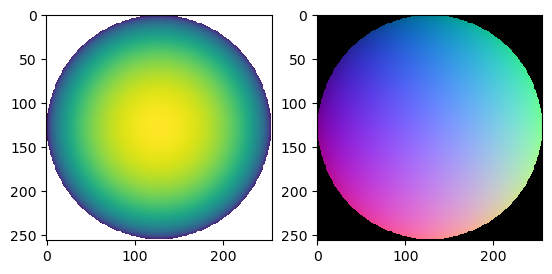

In [105]:
plt.subplot(1, 2, 1)
plt.imshow(z)
plt.subplot(1, 2, 2)
plt.imshow(normals / 2 + 0.5);

First, we define a simple BRDF model. Each BRDF instance should be callable, with two arguments: w_i, and w_o, which are the normalized vectors (omegas) describing the incident and and viewing directions respectively. The idea is to calculate the BRDF for all the points of the sphere at once (vectorized implementation) instead of finding the BRDF value for each point over a loop.

In [106]:
class LambertianBRDF:
    # Simple example for a Lambertian BRDF for virtual object (Green for instance)
    def __init__(self, diffuse_color=(0.0, 1.0, 0.0)):
        self.diffuse_color = np.array(diffuse_color)

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return np.broadcast_to(self.diffuse_color, w_i.shape)  # Broadcast is used to attend to the B x 3 expected shape of the directions

In [107]:
# Write the PhongBRDF in a similar format to the provided LambertianBRDF
class PhongBRDF:
    def __init__(self, diffuse_color=(0.0, 1.0, 0.0), specular_color=(1.0, 1.0, 1.0), alpha=20.0):
        ...

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        ...

In [108]:
def normalize(v):
    """ Utility function that normalizes a vector. Expects shape ... x 3 """
    ...

In [109]:
def get_rotations(a, b=(0.0, 0.0, 1.0)):
    """ Utility function that computes the rotation to bring a vector _a_ to direction _b_. 
        Hint: Keep in mind we are processing the points in parallel manner. That is, shape of vector a is B x 3    
    """
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    skew = ...
    i = ...
    cos = ...
    rotations = i + skew + np.matmul(skew, skew) * (1 / (1 + cos))
    return rotations  # B x 3 x 3

In [110]:
def render_sphere_image(brdf, light_angle: float):
    """
    Returns the rendered sphere given a light direction
    light_angle: float giving the light direction in degrees
    """
    light_angle = np.deg2rad(light_angle)
    light_pos = light_dist * np.array([0, np.sin(light_angle), np.cos(light_angle)])
    camera_pos = camera_dist * np.array([0, 0, 1])
    points = ...  # B x 3 vector using x,y,z defined above
    normals = ...  #  B x 3 vector
    dir_to_light = ...  # Normalized vector of direction from points to light
    dir_to_camera = ...  # Normalized vector of direction from points to camera
    
    rotations = get_rotations(normals)  # Find rotations to bring normals to (0, 0, 1)
    w_i = np.einsum('bij,bj->bi', rotations, dir_to_light)  # Rotate directions in a canonical space
    w_o = np.einsum('bij,bj->bi', rotations, dir_to_camera)  # Rotate directions in a canonical space
    cos = np.einsum('bi,bi->b', dir_to_light, normals)[:, np.newaxis]  # cosine term
    light_out = ...
    
    light_out = light_out.reshape(H, W, 3)
    light_out[~in_frame] = np.nan
    return light_out

In [111]:
def linear_to_srgb(img):
	limit = 0.0031308
	return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

def plot_hdr(image, title=None):
    srgb = linear_to_srgb(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(np.clip(srgb, 0, 1))
    
def create_render(brdf):
    def render(light_angle):
        image = render_sphere_image(brdf, light_angle)
        plt.figure(figsize=(6, 6))
        plt.title("Rendered BRDF")
        plt.axis('off')
        plot_hdr(image)
    return render

In [112]:
brdf = PhongBRDF()
interact(create_render(brdf), brdf=brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

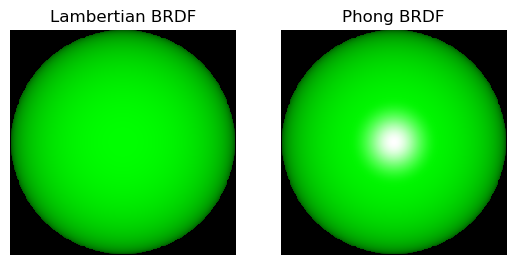

In [113]:
plt.subplot(1, 2, 1)
result = render_sphere_image(LambertianBRDF(), 0.0)
plot_hdr(result, "Lambertian BRDF")
plt.subplot(1, 2, 2)
result = render_sphere_image(PhongBRDF(), 0.0)
plot_hdr(result, "Phong BRDF")

## Load data
We defined and render static, manually adjusted BRDFs. Now will try to infere BRDFs from data.

In [114]:
# Loading paths
data_dir: Path = ...  # Your folder path
angles = ... # The angles for your images 
paths = [data_dir / "crops" / f"angle_{angle}.exr" for angle in angles]

assert len(paths) > 3 and all(p.exists() for p in paths)

hdr_crops = ... # Load and resize the (cropped) HDR images

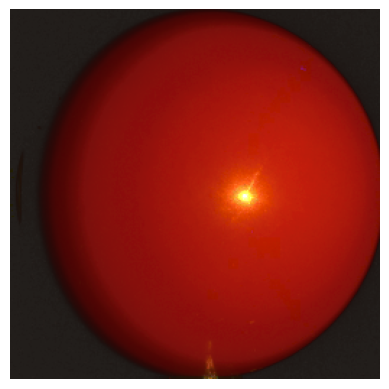

In [115]:
plot_hdr(hdr_crops[1])

In [116]:
def collect_brdf_data(input_image, light_angle = 0.0, cos_eps = 0.01):
    """
    Aggregated the brdf information from the input image, observing a certain light angle
    light_angle: float giving the light direction in degrees
    cos_eps: float threshold to ignore unreliable information (cos < cos_eps)
    Should return 3 np.arrays of shape B x 3
    Tip: Essentially this functions is the inverse counterpart of the rendering function.
    """
    return ...

In [117]:
# Collect the w_i, w_o, and corresponding BRDF values from all images
...
for angle, hdr_crop in zip(angles, hdr_crops):
    ...
w_i = ...
w_o = ...
values = ...

In [118]:
assert w_i.shape == w_o.shape == values.shape

In [119]:
class LambertianFitBRDF():
    def __init__(self):
        super().__init__()
        self.model = LambertianBRDF()
        self.params = np.array(self.model.diffuse_color)
        self.result = None
    
    def run(self, params, w_i, w_o):
        self.model.diffuse_color = params[:3]
        return self.model(w_i, w_o)

    def objective(self, params, w_i, w_o, values):
        prediction = self.run(params, w_i, w_o)
        return np.mean((prediction - values) ** 2)

    def fit(self, w_i, w_o, values):
        self.result = scipy.optimize.minimize(self.objective, x0=self.params, args=(w_i, w_o, values))
        self.params = self.result.x
        return self

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return self.run(self.params, w_i, w_o)

In [120]:
fitted_brdf = LambertianFitBRDF().fit(w_i, w_o, values)

In [121]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

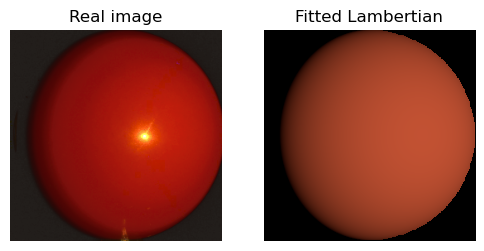

In [122]:
idx = 1
plt.figure(figsize=(6, 12))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Lambertian");

Similar to the LambertianFitBRDF, you are required to provide the code for the methods of the PhongFitBRDF

In [123]:
class PhongFitBRDF():
    def __init__(self):
       ...
    
    def run(self, params, w_i, w_o):
        ...

    def objective(self, params, w_i, w_o, values):
        ...

    def fit(self, w_i, w_o, values):
        ...

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return ...

In [124]:
fitted_brdf = PhongFitBRDF().fit(w_i, w_o, values)

In [125]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

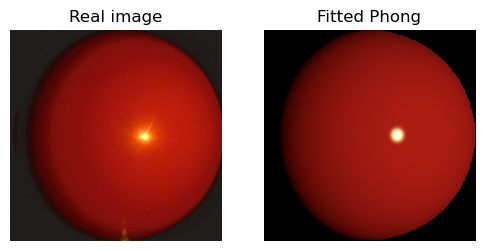

In [126]:
idx = 1
plt.figure(figsize=(6, 12))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Phong");

While the Phong model fits the data significantly better, it still has several limitations.
In this section we will model the BRDF directly using a neural network following the approach proposed by Sztrajman et al. in https://arxiv.org/pdf/2102.05963.pdf 

In [127]:
def default_transform(w_i, w_o):
    return np.concatenate([w_i, w_o], axis=1)

In [128]:
# Neural models generally train better using the Rusinkiewicz parametrization
def to_rusinkiewicz(w_i, w_o):
    return ...

In [129]:
class IndicesDataset(torch.utils.data.Dataset):
    """ Utility class for random batching """
    def __init__(self, tensor):
        super(IndicesDataset, self).__init__()
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, item):
        return self.tensor[item]

In [130]:

class NeuralBRDF:
    def __init__(self, device='cpu', input_size=6, transform=default_transform):
        super().__init__()
        self.device = device
        self.transform = transform
        self.model = ...  # Pytorch MLP
    
    def forward(self, data):
        return ...  # Run the data through the model + the final exponential activation
    
    def _train(self, data, values, weights, epochs):
        weights = weights[:, None].expand_as(values)
        optimizer = ...
        indices = IndicesDataset(torch.arange(0, len(data), device=data.device))
        data_loader = torch.utils.data.DataLoader(indices, batch_size=2000, shuffle=True)
        for _ in range(epochs):
            for chunk in data_loader:
                loss = ...

    def fit(self, w_i, w_o, values, epochs=40):
        data = self.transform(w_i, w_o)
        l_dot_n = torch.tensor(np.clip(w_i[..., 2], 1e-5, 1), dtype=torch.float32, device=self.device)
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        values = torch.tensor(values, dtype=torch.float32, device=self.device)
        self._train(data, values, l_dot_n, epochs)
        return self
    
    def inference(self, data):
        predicted = ...
        return predicted.cpu().numpy()

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        data = ...
        data[~np.isfinite(data)] = 0
        return ...

In [94]:
fitted_brdf = NeuralBRDF(input_size=6, transform=to_rusinkiewicz).fit(w_i, w_o, values)

0.01715831086039543
0.010176736861467361
0.007312708999961615
0.004399023950099945
0.004896723665297031
0.005742684938013554
0.00670348946005106
0.006061899941414595
0.004296619910746813
0.003201131010428071
0.0029597433749586344
0.004315420053899288
0.007213382050395012
0.0026972112245857716
0.0026733779814094305
0.0071358573623001575
0.004417954478412867
0.007093952968716621
0.0037877506110817194
0.007131932303309441
0.0027510314248502254
0.0034931248519569635
0.00588998943567276
0.006913430988788605
0.0035146132577210665
0.002613207558169961
0.0023643504828214645
0.0026989602483808994
0.002496361033990979
0.003372720442712307
0.002750939456745982
0.0032793397549539804
0.0031786917243152857
0.003548353910446167
0.002534576691687107
0.0029339673928916454
0.002409842563793063
0.0034754150547087193
0.003373535815626383
0.002928786212578416


In [99]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

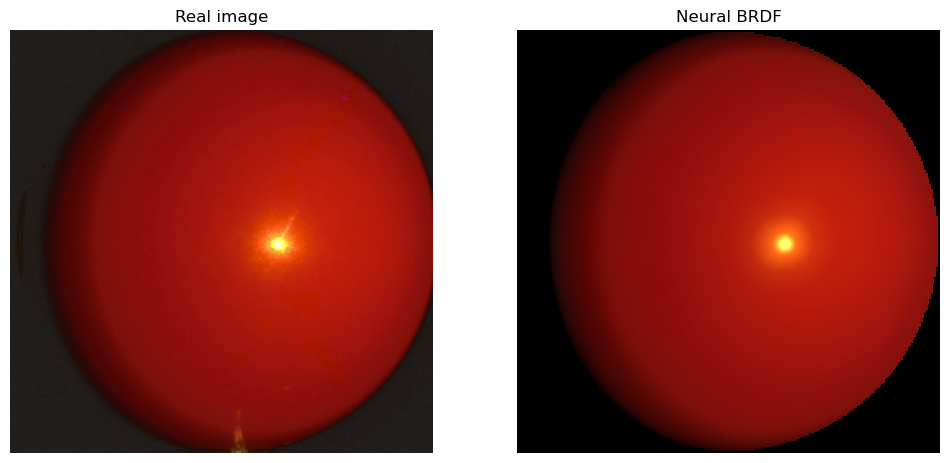

In [100]:
idx = 1
plt.figure(figsize=(12, 24))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Neural BRDF");

In this section you should evaluate the rendered images, comparing them to the camera captures.
Visualize and compute metrics for the Phong and Neural fitted BRDFs.

In [101]:
mse = 0
ssim = 0

As the last task describe in text your observations regarding:
* How do the Phong and Neural BRDFs compare visually and in terms of metrics.
* How do the two (or more) captured spheres compare. To work with the second material you can duplicate the fitting cells in this notebook or create another notebook for it.
* Optionally, you can describe the effect of using different parametrizations, architectures, and loss functions for Neural BRDFs.